# Intro

It's the last time we meet in class for exercises! And to celebrate this mile-stone, I've put together an very nice little set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - That's it!


# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.



> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.



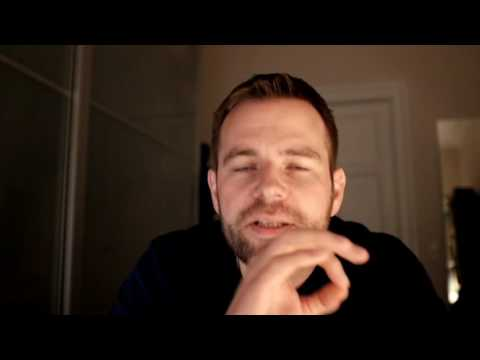

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

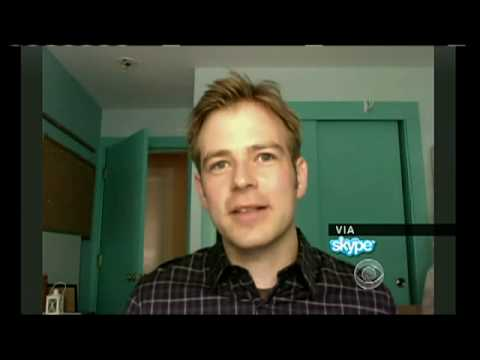

In [2]:
# There's also this one from 2010
YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.
> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.
> * Who are the 10 artists with happiest and saddest pages?

<div class="alert alert-block alert-info">
As long as you get the plots right, it's OK to use LLM help here.
</div>

*Exercise*: Community sentiment distribution. 
  
> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected characters. 
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

<div class="alert alert-block alert-info">
As above, feel free to go nuts with help from an LLM with this exercise for the technical parts. But try to answer the questions about interpreting the results with your own human brain.
</div>

**Note**: Calculating sentiment takes a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

In [2]:
import pandas as pd

# Adjust the file path and delimiter if needed
labmt_df = pd.read_csv(r"Data_Set_S1.txt", delim_whitespace=True, header=None, names=["word", "happiness_rank", "happiness_average", "happines_standard_deviation","twitter_rank","google_rank","nyt_rank","lyrics_rank"],skiprows=4)
labmt_df.head()

C:\Users\jdiaz\AppData\Local\Temp\ipykernel_13520\2604751072.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labmt_df = pd.read_csv(r"Data_Set_S1.txt", delim_whitespace=True, header=None, names=["word", "happiness_rank", "happiness_average", "happines_standard_deviation","twitter_rank","google_rank","nyt_rank","lyrics_rank"],skiprows=4)


,word,happiness_rank,happiness_average,happines_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [3]:
# Create a dictionary with words as keys and happiness scores as values
labmt_dict = pd.Series(labmt_df.happiness_average.values, index=labmt_df.word).to_dict()

# Verify a few entries
print(labmt_dict.get("laughter"))  # Should return the happiness score for "laughter"
print(labmt_dict.get("happiness"))  # Should return the happiness score for "happiness"

8.5
8.44


Exercise: Sentiment distribution.

In [4]:
def calculate_sentiment(tokens, labmt_dict):
    sentiments = [labmt_dict.get(word, None) for word in tokens if word in labmt_dict]
    sentiments = [s for s in sentiments if s is not None]  # Filter out None values
    if not sentiments:
        return None  # Return None if there are no recognized words
    return sum(sentiments) / len(sentiments)

calculate_sentiment("gammes joy", labmt_dict)

4.948888888888888

In [5]:
import re
import string
import ast
from collections import Counter
from bs4 import BeautifulSoup
from urllib.request import urlopen
import nltk
import os

# Ensure you have the NLTK data downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load artist-genre dictionary from a text file
artist_genre_dict = {}
with open(r'C:\Users\jdiaz\Desktop\DTU_SocialGraphs\socialgraphs2024\artists_genres_dictionary.txt', 'r', encoding='utf-8') as f:
    content = f.read()
    artist_genre_dict = ast.literal_eval(content)  # Safely evaluate the dictionary format

# Initialize a dictionary to hold the Term Frequency (TF) data for each genre
tf_lists = {genre: Counter() for genre in set(genre for genres in artist_genre_dict.values() for genre in genres)}

# Function to fetch Wikipedia content
wiki_path = "https://en.wikipedia.org/wiki/"

# Define a directory to save artist token files
token_dir = "artist_tokens"
os.makedirs(token_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Process each artist
for artist, genres in artist_genre_dict.items():
    try:
        # Clean the artist's name (remove parentheses and their contents)
        artist_cleaned = re.sub(r'\s*\(.*?\)', '', artist)  # Removes "(musician)" etc.

        # Fetch the Wikipedia page
        artist_url = wiki_path + artist_cleaned.replace(" ", "_")
        source = urlopen(artist_url).read()
        soup = BeautifulSoup(source, "html.parser")

        # Extract the plain text content from paragraphs
        text = ''
        for paragraph in soup.find_all('p'):
            text += paragraph.text

        # Clean the text: remove footnotes, newlines, and punctuation
        text = re.sub(r'\[.*?\]+', '', text)
        text = text.replace('\n', '')
        text = text.translate(str.maketrans('', '', string.punctuation)).lower()

        # Tokenization
        tokens = nltk.word_tokenize(text)

        # Save tokens to a file for each artist
        artist_filename = f"{artist_cleaned.replace(' ', '_')}_tokens.txt"
        artist_filepath = os.path.join(token_dir, artist_filename)

        with open(artist_filepath, 'w', encoding='utf-8') as file:
            file.write(" ".join(tokens))  # Save tokens as a space-separated string

        # Update the Counter for each genre associated with the artist
        for genre in genres:
            tf_lists[genre].update(tokens)

    except Exception as e:
        print(f"Error fetching data for {artist}: {e}")

KeyboardInterrupt: 

In [10]:
import os
token_dir = "artist_tokens"

# Initialize variables to store sentiment values
sentiments = []
artist_sentiments = {}  # Store each artist's sentiment for easier reference later

# Iterate over all files in the token directory
for filename in os.listdir(token_dir):
    artist_name = filename.replace('_tokens.txt', '').replace('_', ' ')  # Extract artist name from file name
    artist_filepath = os.path.join(token_dir, filename)
    
    with open(artist_filepath, 'r', encoding='utf-8') as file:
        tokens = file.read().split()  # Split by spaces to retrieve tokens
        
        # Calculate sentiment for this artist's tokens
        sentiment = calculate_sentiment(tokens, labmt_dict)
        if sentiment is not None:
            sentiments.append(sentiment)
            artist_sentiments[artist_name] = sentiment

In [12]:
len(sentiments)

1824

In [14]:
import numpy as np
# Calculate summary statistics
mean_sentiment = np.mean(sentiments)
median_sentiment = np.median(sentiments)
variance_sentiment = np.var(sentiments)
percentile_25 = np.percentile(sentiments, 25)
percentile_75 = np.percentile(sentiments, 75)

# Print summary statistics
print("Sentiment Statistics:")
print(f"Mean: {mean_sentiment}")
print(f"Median: {median_sentiment}")
print(f"Variance: {variance_sentiment}")
print(f"25th Percentile: {percentile_25}")
print(f"75th Percentile: {percentile_75}")

Sentiment Statistics:
Mean: 5.565347773504527
Median: 5.570014028056097
Variance: 0.010956520030158378
25th Percentile: 5.5101687996469515
75th Percentile: 5.625597758517788


In [15]:
# Find the 10 happiest and saddest artists
sorted_artists = sorted(artist_sentiments.items(), key=lambda item: item[1])
saddest_artists = sorted_artists[:10]
happiest_artists = sorted_artists[-10:]

print("\n10 Saddest Artists:")
for artist, sentiment in saddest_artists:
    print(f"{artist}: {sentiment}")

print("\n10 Happiest Artists:")
for artist, sentiment in happiest_artists:
    print(f"{artist}: {sentiment}")


10 Saddest Artists:
The Highwaymen: 4.960000000000001
The Devil Makes Three: 4.991428571428571
Billy Yates: 5.071428571428571
Bill Chambers: 5.086666666666667
Bill Phillips: 5.1000000000000005
Ricochet: 5.100643821391466
Al Anderson: 5.160000000000001
Ron Wallace: 5.171428571428572
Hal Willis: 5.21
George Ducas: 5.235927272727277

10 Happiest Artists:
Troy Cassar-Daley: 5.837942283563363
Doc Walker: 5.848235294117651
Sean Hogan: 5.8967857142857145
Don Amero: 5.905266903914588
Jessie Farrell: 5.91573643410853
Cassandra Vasik: 5.92825396825397
McAlister Kemp: 5.948941176470587
Great Speckled Bird: 5.989999999999999
McKenna Faith: 6.041538461538462
Home Free: 6.308


Exercise


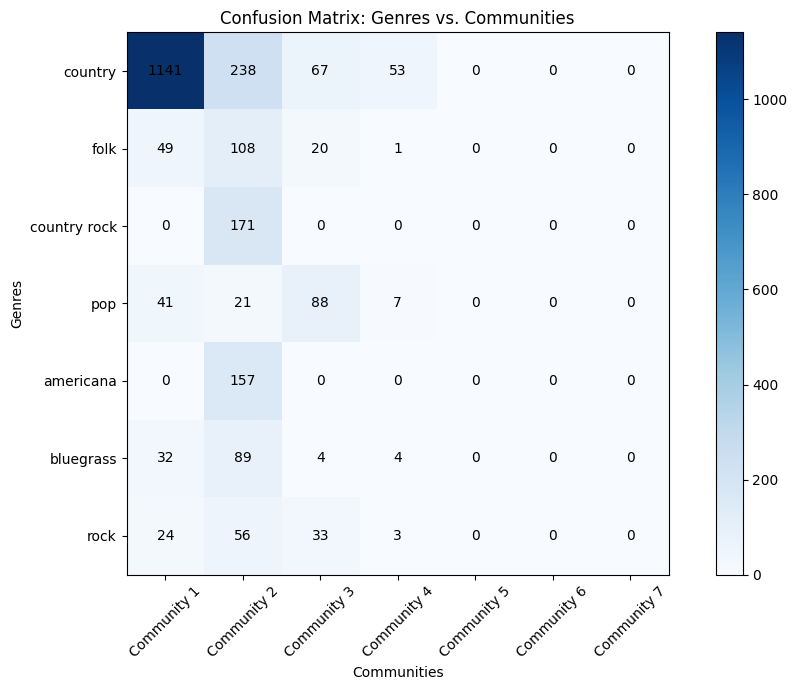

In [18]:
import networkx as nx
import ast
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from networkx.algorithms.community import louvain_communities
from itertools import combinations


# Step 1: Load the dictionary from a text file
def load_genre_dictionary(file_path):
    with open(file_path, 'r') as file:
        genre_dict = ast.literal_eval(file.read())  # Safely evaluate the string representation of the dictionary
    return genre_dict

# Step 2: Create the edge list based on shared genres
def create_edge_list(genre_dict):
    edge_list = []
    artists = list(genre_dict.keys())
    
    # Compare each pair of artists
    for artist1, artist2 in combinations(artists, 2):
        genres1 = set(genre_dict[artist1])
        genres2 = set(genre_dict[artist2])
        
        # If they share at least one genre, create an edge
        if genres1.intersection(genres2):
            edge_list.append((artist1, artist2))
    
    return edge_list

# Step 3: Create the subnetwork (only nodes with genre information)
def create_subnetwork(graph, genre_dict):
    nodes_with_genres = set(genre_dict.keys())
    return graph.subgraph(nodes_with_genres)

# Step 4: Apply Louvain algorithm using networkx
def apply_louvain_communities(graph):
    communities = louvain_communities(graph)  # Find Louvain communities
    return communities

# Step 5: Identify the 7 most common genres and 7 largest communities
def get_top_genres_and_communities(genre_dict, communities):
    # Get top 7 most common genres
    all_genres = [genre for genres in genre_dict.values() for genre in genres]
    genre_counter = Counter(all_genres)
    top_genres = [genre for genre, _ in genre_counter.most_common(7)]
    
    # Get top 7 largest communities
    community_sizes = [len(community) for community in communities]
    top_communities = sorted(communities, key=lambda x: len(x), reverse=True)[:7]
    
    return top_genres, top_communities

# Step 6: Create the confusion matrix
def create_confusion_matrix(genre_dict, top_genres, top_communities):
    # Initialize the confusion matrix
    D = np.zeros((len(top_genres), len(top_communities)))

    # Map genre to index
    genre_to_index = {genre: idx for idx, genre in enumerate(top_genres)}
    
    # Loop through top communities
    for j, community in enumerate(top_communities):
        for node in community:
            if node in genre_dict:
                # Get the genres of the node
                node_genres = genre_dict[node]
                
                # Increment the matrix if the genre is in the top 7 genres
                for genre in node_genres:
                    if genre in genre_to_index:
                        i = genre_to_index[genre]
                        D[i, j] += 1
                        
    return D

# Step 7: Visualize the confusion matrix
def visualize_confusion_matrix(D, top_genres, top_communities):
    plt.figure(figsize=(10, 7))
    plt.imshow(D, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Genres vs. Communities")
    plt.colorbar()
    
    # Set genre and community labels
    plt.xticks(np.arange(len(top_communities)), [f"Community {i+1}" for i in range(len(top_communities))], rotation=45)
    plt.yticks(np.arange(len(top_genres)), top_genres)
    
    # Display the values in the matrix
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            plt.text(j, i, int(D[i, j]), ha='center', va='center', color='black')

    plt.xlabel("Communities")
    plt.ylabel("Genres")
    plt.tight_layout()
    plt.show()

# Step 8: Main function
def main(genre_file_path):
    # Load genre dictionary
    genre_dict = load_genre_dictionary(genre_file_path)

    # Create the edge list based on shared genres
    edge_list = create_edge_list(genre_dict)
    
    # Create a graph from the edge list
    graph = nx.Graph(edge_list)

    # Create the subnetwork (only with nodes that have genres)
    subgraph = create_subnetwork(graph, genre_dict)

    # Apply Louvain algorithm using networkx
    communities = apply_louvain_communities(subgraph)

    # Identify the top 7 most common genres and largest communities
    top_genres, top_communities = get_top_genres_and_communities(genre_dict, communities)

    # Create the confusion matrix
    D = create_confusion_matrix(genre_dict, top_genres, top_communities)

    # Visualize the confusion matrix
    visualize_confusion_matrix(D, top_genres, top_communities)
    return graph,communities

    
 # Example usage
genre_file_path = r"C:\Users\jdiaz\Desktop\DTU_SocialGraphs\socialgraphs2024\artists_genres_dictionary.txt"
graph,communities = main(genre_file_path)

In [20]:
import numpy as np
from collections import defaultdict

# Assuming artist_sentiments is already populated from your previous code
# and `communities` is a list of sets, each containing artist names for one community.

def calculate_average_community_sentiment(communities, artist_sentiments, num_top_communities=10):
    # Filter for the top N communities (by size)
    top_communities = sorted(communities, key=len, reverse=True)[:num_top_communities]
    community_sentiments = {}
    
    # Calculate the average sentiment for each community
    for idx, community in enumerate(top_communities):
        sentiments = [artist_sentiments[artist] for artist in community if artist in artist_sentiments]
        
        # Average sentiment for the community
        if sentiments:
            avg_sentiment = np.mean(sentiments)
            # Find top 3 artists by degree within the community for naming
            top_artists = sorted(community, key=lambda artist: graph.degree[artist], reverse=True)[:3]
            community_name = ', '.join(top_artists)
            community_sentiments[community_name] = avg_sentiment
            print(f"Community {idx+1} ({community_name}): Average Sentiment = {avg_sentiment}")
    
    return community_sentiments

# Run the function to get average sentiment for each community
community_sentiments = calculate_average_community_sentiment(communities, artist_sentiments)

# Identify the three happiest and three saddest communities
sorted_communities = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)
happiest_communities = sorted_communities[:3]
saddest_communities = sorted_communities[-3:]

print("\nThree Happiest Communities:")
for name, sentiment in happiest_communities:
    print(f"{name}: {sentiment}")

print("\nThree Saddest Communities:")
for name, sentiment in saddest_communities:
    print(f"{name}: {sentiment}")

# Compare to overall average sentiment
overall_avg_sentiment = np.mean(list(artist_sentiments.values()))
print(f"\nOverall Average Sentiment (Entire Network): {overall_avg_sentiment}")

# Evaluate community sentiment difference from overall network sentiment
for name, sentiment in happiest_communities + saddest_communities:
    diff = sentiment - overall_avg_sentiment
    print(f"{name} sentiment difference from overall: {diff:+.2f}")


Community 1 (Jerry Lee Lewis, Larry Campbell (musician), Al Downing (musician)): Average Sentiment = 5.584956705495383
Community 2 (Gene Clark, Zac Brown, Ashley McBryde): Average Sentiment = 5.576025413488752
Community 3 (Gordon Lightfoot, John Denver, Lobo (musician)): Average Sentiment = 5.579142867007112
Community 4 (Dolly Parton, Hunter Hayes, Vince Gill): Average Sentiment = 5.621362720065766
Community 5 (Bill Engvall, Steve Martin, Larry the Cable Guy): Average Sentiment = 5.572484498389602
Community 6 (Lorenzo Antonio, Sparx (US band)): Average Sentiment = 5.561972413793087
Community 7 (Susan McCann, Larry Cunningham): Average Sentiment = 5.58977190868314

Three Happiest Communities:
Dolly Parton, Hunter Hayes, Vince Gill: 5.621362720065766
Susan McCann, Larry Cunningham: 5.58977190868314
Jerry Lee Lewis, Larry Campbell (musician), Al Downing (musician): 5.584956705495383

Three Saddest Communities:
Gene Clark, Zac Brown, Ashley McBryde: 5.576025413488752
Bill Engvall, Steve Ma